In [1]:
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [6]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
    #                         mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                         mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                         ) 
    # Draw pose connections
    #mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
    #                         mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
    #                         mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
    #                         ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [8]:
# Path for exported data, numpy arrays
# Step 4
DATA_PATH = os.path.join('ISL_Data')
actions = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])

# no of videos
no_sequences = 30

# no of frames in each video
sequence_length = 30

label_map = {label:num for num, label in enumerate(actions)}
#label_map

new_actions = np.array(['C', 'O'])
new_label_map = {label:num for num, label in enumerate(new_actions)}
#new_label_map

new_actions1 = np.array(['M', 'N'])
new_label_map1 = {label:num for num, label in enumerate(new_actions1)}
#new_label_map1

In [9]:
from keras.models import load_model

In [10]:
# change the .h5 file with the one you saved
model = load_model('actionA_to_ZNew.h5')

In [11]:
model_c_and_o = load_model('actionCO.h5')

In [12]:
model_mn = load_model('actionMN.h5')

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 28, 32)            12128     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 5, 128)            24704     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 2, 128)          

In [14]:
#ASCII
keys = [' ','!','"','#','$','%','&','','(',')','*','+',',','-','.','/',
          '0','1','2','3','4','5','6','7','8','9',':',';','<','=','>','?','@',
          'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q',
          'R','S','T','U','V','W','X','Y','Z','[','\\',']','^','_']

# Braille symbols
values = ['⠀','⠮','⠐','⠼','⠫','⠩','⠯','⠄','⠷','⠾','⠡','⠬','⠠','⠤','⠨','⠌','⠴','⠂','⠆','⠒','⠲','⠢',
        '⠖','⠶','⠦','⠔','⠱','⠰','⠣','⠿','⠜','⠹','⠈','⠁','⠃','⠉','⠙','⠑','⠋','⠛','⠓','⠊','⠚','⠅',
        '⠇','⠍','⠝','⠕','⠏','⠟','⠗','⠎','⠞','⠥','⠧','⠺','⠭','⠽','⠵','⠪','⠳','⠻','⠘','⠸']

braille_lookup = dict(zip(keys, values))

In [15]:
from PIL import Image, ImageFont, ImageDraw

In [43]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
lst = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        img = image
        #print(results)
        
        # Draw landmarks
        #draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            
            res2 = model_c_and_o.predict(np.expand_dims(sequence, axis=0))[0]
            res3 = model_mn.predict(np.expand_dims(sequence, axis=0))[0]
            
            index = np.argmax(res)
            pred = actions[np.argmax(res)]
            prob = res[index]
            
            if pred == 'C' or pred == 'O':
                pred = new_actions[np.argmax(res2)], 
                pred = pred[0]
                index = 2 if pred == 'C' else 14,
                index = index[0]
                prob = res[index]

            if pred == 'M' or pred == 'N':
                pred = new_actions1[np.argmax(res3)],
                pred = pred[0]
                index = 12 if pred == 'M' else 13,
                index = index[0]
                prob = res[index]
                
            predictions.append(index)
            #print("{} {} {}".format(pred, index, prob))
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==index: 
                if prob > threshold: 
                    #print(braille_lookup[actions[np.argmax(res)]])
                    if len(sentence) > 0: 
                        if braille_lookup[pred] != sentence[-1]:
                            sentence.append(braille_lookup[pred])
                    else:
                        sentence.append(braille_lookup[pred])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
            
            # Viz probabilities
            cv2.putText(image, "Prediction: "+pred, (0, 85), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
            #image = prob_viz(res, actions, image, colors)
            #cv2.putText(image, "Prediction: "+new_actions[np.argmax(res2)], (0, 125), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
            #image = prob_viz(res, actions, image, colors)
        
        #cv2.rectangle(image, (500,50), (900, 150), (245, 117, 16), -1)
        
            img = image #np.zeros((200,400,3),np.uint8)
            b,g,r,a = 0,0,255,0

            font = ImageFont.truetype(r'unifont1.ttf', 40)

            img_pil = Image.fromarray(img)
            draw = ImageDraw.Draw(img_pil)
            draw.text((3, 0),  "Braille: "+braille_lookup[pred], font = font, fill = (b, g, r, a))
            img = np.array(img_pil)

            cv2.putText(img, "", (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
            #image = prob_viz(res, actions, image, colors)

        #cv2.putText(img, "", (200,150), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (b,g,r), 1, cv2.LINE_AA)
        #print(''.join(sentence))
        
        lst.append(img)
        # Show to screen
        cv2.imshow('OpenCV Feed', img)
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    
    cv2.destroyAllWindows()

O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999557733535767
O 14 0.9999845027923584
O 14 0.9999896287918091
O 14 0.9998140931129456
O 14 0.9990447163581848
O 14 0.9651790857315063
C 2 0.06489662826061249
Z 25 0.9982656836509705
Q 16 0.21258419752120972
Z 25 0.9669591188430786
Z 25 0.975186288356781
Z 25 0.9982073307037354
Q 16 0.9848279356956482
Q 16 0.9355801343917847
Q 16 0.9073469042778015
Q 16 0.9509245157241821
Q 16 0.9817627668380737
T 19 0.798684895

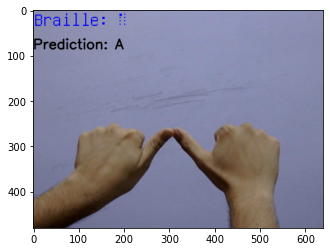

In [49]:
fram = lst[101]
fram1 = cv2.cvtColor(fram, cv2.COLOR_BGR2RGB)
picture = plt.imshow(fram1)
#picture.savefig('A_result.pdf', dpi=700)
picture.get_figure().savefig('A_result.pdf', dpi=700)
#picture

In [20]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import lite

SAVED_MODEL = "saved_models"
tf.saved_model.save(model, SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models\assets


In [21]:
#sigmodel = hub.load(SAVED_MODEL)
TFLITE_MODEL = "tflite_models/sign.tflite"
TFLITE_QUANT_MODEL = "tflite_models/sign_quant.tflite"

In [22]:
def convert_to_tflite():
    converter = lite.TFLiteConverter.from_keras_model(model)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.experimental_new_converter = True
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                           tf.lite.OpsSet.SELECT_TF_OPS]

    converted_tflite_model = converter.convert()
    open(TFLITE_MODEL, "wb").write(converted_tflite_model)

    converter = lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
    converter.experimental_new_converter = True
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                           tf.lite.OpsSet.SELECT_TF_OPS]

    tflite_quant_model = converter.convert()
    open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

In [23]:
def use_tflite(X_test, y_test):
    tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()

    tflite_interpreter.resize_tensor_input(
        input_details[0]['index'], X_test.shape)
    tflite_interpreter.resize_tensor_input(
        output_details[0]['index'], y_test.shape)
    tflite_interpreter.allocate_tensors()

    input_details = tflite_interpreter.get_input_details()
    output_details = tflite_interpreter.get_output_details()

    # Load quantized TFLite model
    tflite_interpreter_quant = tf.lite.Interpreter(
        model_path=TFLITE_QUANT_MODEL)

    # Learn about its input and output details
    input_details = tflite_interpreter_quant.get_input_details()
    output_details = tflite_interpreter_quant.get_output_details()

    # Resize input and output tensors
    tflite_interpreter_quant.resize_tensor_input(
        input_details[0]['index'], X_test.shape)
    tflite_interpreter_quant.resize_tensor_input(
        output_details[0]['index'], y_test.shape)
    tflite_interpreter_quant.allocate_tensors()

    input_details = tflite_interpreter_quant.get_input_details()
    output_details = tflite_interpreter_quant.get_output_details()

    # Run inference
    tflite_interpreter_quant.set_tensor(input_details[0]['index'], X_test)

    tflite_interpreter_quant.invoke()

    tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(
        output_details[0]['index'])
#print("\nPrediction results shape:", tflite_q_model_predictions.shape)

In [25]:
convert_to_tflite()

INFO:tensorflow:Assets written to: C:\Users\SHUBHAM\AppData\Local\Temp\tmpp2dfvhcb\assets


INFO:tensorflow:Assets written to: C:\Users\SHUBHAM\AppData\Local\Temp\tmpp2dfvhcb\assets


INFO:tensorflow:Assets written to: C:\Users\SHUBHAM\AppData\Local\Temp\tmpbdmxbw5k\assets


INFO:tensorflow:Assets written to: C:\Users\SHUBHAM\AppData\Local\Temp\tmpbdmxbw5k\assets
